In [29]:
import numpy as np
import scipy as sp
import sklearn as skl
import skimage as ski
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sb

In [5]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/run04")

os.makedirs(workdir, exist_ok=True)

In [6]:
descriptors = list(dataset.glob("hist_*.npy"))
descriptors

[WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R3_P24_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R5_P36_u.npy')]

In [13]:
descriptor = 'R1P8d+R2P12u'

In [12]:
chunksize = 100

In [11]:
y = np.load(f"{dataset}/labels.npy")
print(y.shape, y.dtype)
label = y[:,1]
label_subset = y[:,0]

(1950, 2) uint8


# Descriptor R1P8d+R2P12u

## 1. Mean

In [85]:
X1 = np.load(f"{dataset}/hist_R1_P8_d.npy")
X1.shape, X1.dtype

((1950, 256), dtype('uint32'))

In [86]:
X2 = np.load(f"{dataset}/hist_R2_P12_u.npy")
X2 = (X2[:,:13] * (chunksize**2 / (chunksize**2-X2[:,13])).reshape(-1,1))
X2.shape, X2.dtype

((1950, 13), dtype('float64'))

In [87]:
X2.sum(axis=1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], shape=(1950,))

In [88]:
X = np.concat([X1, X2], axis=1)
X.shape, X.dtype

((1950, 269), dtype('float64'))

In [89]:
unique_labels, label_sizes = np.unique(label, return_counts=True)
nlabels = len(unique_labels)
unique_labels, label_sizes, nlabels

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint8),
 array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]),
 13)

features stratified by class/label

In [90]:
X_cl = np.array([ X[label == k] for k in unique_labels ])
X_cl.shape, X_cl.dtype

((13, 150, 269), dtype('float64'))

mean histogram for each class

In [91]:
means = X_cl.mean(axis=1)
means.shape, means.dtype

((13, 269), dtype('float64'))

In [92]:
np.save(workdir / 'X_cl.npy', X_cl)
np.save(workdir / 'means.npy', means)

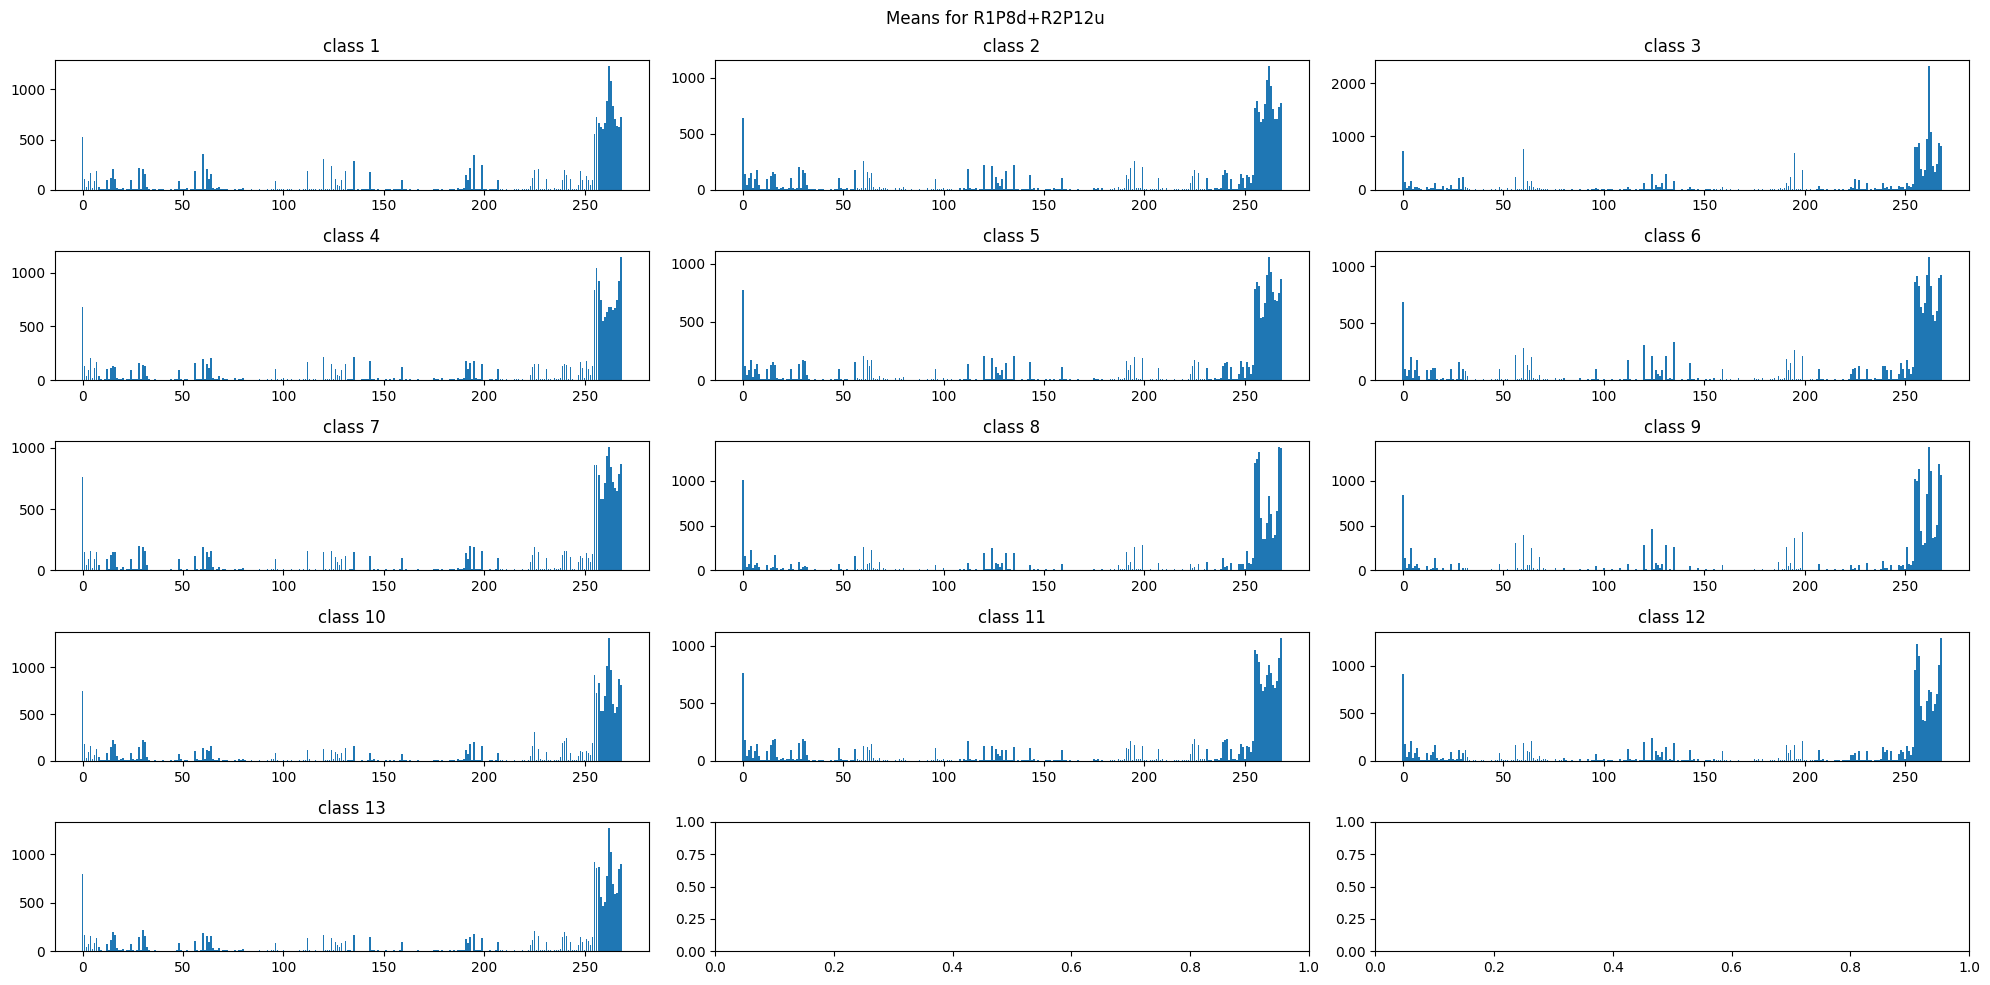

In [93]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.bar(range(means.shape[1]), means[k])
    ax.set_title(f'class {k+1}')
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Means for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

## 4. Performance

In [109]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, label, test_size=0.4, random_state=255, stratify=label)
X_train.shape, y_train.shape

((1170, 269), (1170,))

In [110]:
unique_labels, label_sizes = np.unique(y_train, return_counts=True)
X_train_cl = np.array([ X_train[y_train == k] for k in unique_labels])
means_train = X_train_cl.mean(axis=1) + 1   # +1 to avoid small values

In [111]:
def predict_naive(x):
    # x should be a non-normed histogram
    distances, pvalues = sp.stats.power_divergence( f_obs=(x+1), f_exp=means_train, axis=1, lambda_='log-likelihood')
    assert len(distances) == len(unique_labels)
    return unique_labels[np.argmin(distances)]

In [112]:
pred_classes = np.zeros_like(y_test)
for i in tqdm(range(y_test.shape[0])):
    pred_classes[i] = predict_naive(X_test[i])


100%|██████████| 780/780 [00:00<00:00, 2594.51it/s]


In [113]:
confusion = skl.metrics.confusion_matrix(y_test, pred_classes, labels=unique_labels)

Text(0.5, 1.0, 'R1P8d+R2P12u. Naive argmin-log-L-stat classifier')

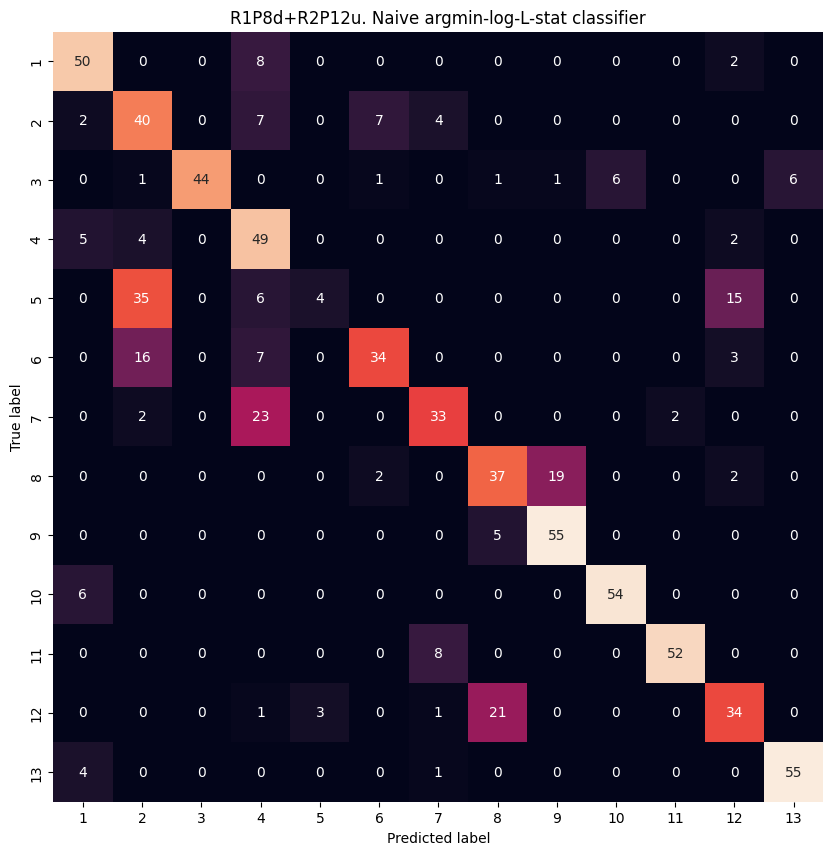

In [114]:
sb.heatmap(confusion, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, square=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.gcf().set_size_inches((10,10))
plt.title(f"{descriptor}. Naive argmin-log-L-stat classifier")

In [115]:
print(f"Balanced accuracy score: {skl.metrics.balanced_accuracy_score(y_test, pred_classes):.3f}")
print(f"F1-score[macro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='macro'):.3f}")
print(f"F1-score[micro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='micro'):.3f}")

Balanced accuracy score: 0.694
F1-score[macro]: 0.681
F1-score[micro]: 0.694
